In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install dask matplotlib seaborn pandas numpy --quiet

print("\033[92m✅ All required packages installed successfully.\033[0m")

✅ All required packages installed successfully.


#### Import libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from concurrent.futures import ThreadPoolExecutor

In [8]:
# dfraw = pd.read_parquet("/home/data/processed/EDA.parquet")
dfraw = pd.read_parquet("/content/drive/MyDrive/datasets/processed/EDAcolab.parquet")

In [9]:
df = dfraw

In [10]:
df

,Timestamp [s],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],VM
0,1376314846,4,11703.998240,10912.027692,93.233333,67108864.0,6.129274e+06,0.133333,15981.600000,0.000000,2.133333,1
1,1376314846,1,2399.999679,71.999990,3.000000,4177920.0,0.000000e+00,0.000000,7.066667,0.000000,0.000000,965
2,1376314846,1,2599.999302,20.799994,0.800000,132136.0,5.190160e+04,0.000000,0.333333,0.000000,0.000000,1066
3,1376314846,2,5851.998768,206.770623,3.533333,8353792.0,4.026512e+05,545.400000,84.000000,1.533333,0.000000,885
4,1376314846,1,2699.998474,25.199986,0.933333,107588.0,3.897013e+04,0.000000,0.200000,0.000000,0.000000,1048
...,...,...,...,...,...,...,...,...,...,...,...,...
11221795,1378906798,0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,542
11221796,1378906798,1,2925.999126,0.000000,0.000000,1034240.0,1.887120e+04,0.000000,1.466667,0.000000,0.000000,1219
11221797,1378906798,1,2599.999620,3.466666,0.133333,4061184.0,5.284800e+05,0.000000,2.000000,0.000000,0.000000,848
11221798,1378906798,1,2925.999538,11.703998,0.400000,2097152.0,1.593816e+05,0.000000,6.666667,0.000000,0.066667,54


In [11]:
# 🧹 Duplicates
print("\n🧹 Duplicate Row Count:", df.duplicated().sum())


🧹 Duplicate Row Count: 452322


In [12]:
total_rows = len(df)
duplicate_rows = df.duplicated().sum()
dup_percent = (duplicate_rows / total_rows) * 100
print(f"Duplicates: {dup_percent:.2f}% of total rows")

Duplicates: 4.03% of total rows


In [13]:
# Group and count how many times each duplicate occurs
duplicate_rows = df[df.duplicated(keep=False)]
grouped_dupes = duplicate_rows.groupby(duplicate_rows.columns.tolist()).size().reset_index(name='Count')
grouped_dupes.sort_values(by='Count', ascending=False).head()

,Timestamp [s],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],VM,Count
63047,1377601377,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,626,3
63046,1377601377,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,625,3
63045,1377601377,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,624,3
63044,1377601377,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,623,3
20146,1377166040,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,731,3


In [14]:
duplicate_rows['VM'].value_counts().head()

,count
VM,
844,15085
842,15085
61,15085
667,15085
1213,15085


In [15]:
df1 = df.copy()

# Step 1: Remove exact full-row duplicates first
df1 = df1.drop_duplicates()

# Step 2: Convert Timestamp safely
df1['Timestamp'] = pd.to_datetime(df1['Timestamp [s]'], unit='s')

# Step 3: Sort by VM and Timestamp
df1 = df1.sort_values(by=['VM', 'Timestamp']).reset_index(drop=True)
df1['time_idx'] = df1.groupby('VM').cumcount()

In [16]:
# 🧹 Duplicates
print("\n🧹 Duplicate Row Count:", df1.duplicated().sum())


🧹 Duplicate Row Count: 0


In [17]:
# Compute Time Difference
df1['time_diff'] = df1.groupby('VM')['Timestamp'].diff()

In [18]:
# Check Most Common Time Differences

df1['time_diff'].value_counts().head(10)

,count
time_diff,
0 days 00:05:00,9463104
0 days 00:05:01,324430
0 days 00:04:59,56435
0 days 00:10:00,7378
0 days 00:00:07,5434
0 days 00:04:53,5434
0 days 00:04:26,5179
0 days 00:00:34,5179
0 days 00:04:29,5034


In [19]:
# Replace timestamp column for resampling
df1 = df1.rename(columns={"Timestamp": "timestamp"})

# Container for cleaned/resampled data
resampled_vms = []

for vm, vm_df in df1.groupby("VM"):
    vm_df = vm_df.set_index("timestamp").sort_index()

    # Select only numeric columns for resampling
    numeric_cols = vm_df.select_dtypes(include=np.number)

    # Resample to exact 5-minute intervals and calculate the mean of numeric columns
    vm_df_resampled = numeric_cols.resample("5min").mean()

    # Forward-fill small gaps (max 3 consecutive)
    vm_df_resampled = vm_df_resampled.ffill(limit=3)

    # Drop rows still containing NaNs
    vm_df_resampled = vm_df_resampled.dropna(how="any")

    # Add VM back
    vm_df_resampled = vm_df_resampled.reset_index()
    vm_df_resampled["VM"] = vm

    resampled_vms.append(vm_df_resampled)

# Combine all VMs into one cleaned dataframe
df1_cleaned = pd.concat(resampled_vms, ignore_index=True)

In [20]:
# First, make sure timestamp is in datetime and sorted per VM
df1_cleaned = df1_cleaned.sort_values(by=['VM', 'timestamp'])

# Compute time difference per VM
df1_cleaned['time_diff'] = df1_cleaned.groupby("VM")['timestamp'].diff()

# Check most common differences
print(df1_cleaned['time_diff'].value_counts().head(10))

time_diff
0 days 00:05:00    10328343
0 days 00:10:00         462
0 days 00:20:00          41
Name: count, dtype: int64


In [21]:
# Do NOT drop based on time_diff.
# Instead, just log/count them:

# Optional: Check rare gaps
rare_gaps = df1_cleaned[df1_cleaned['time_diff'] != pd.Timedelta(minutes=5)]

# See affected VMs and how many times
gap_summary = rare_gaps.groupby("VM").size().sort_values(ascending=False)
print(gap_summary.head())

VM
382    4
280    4
486    4
227    4
453    4
dtype: int64


In [22]:
df1 = df1_cleaned.copy()

In [23]:
# Remove constant columns
constant_cols = df1.columns[df1.nunique() <= 1]
print(f"Removing constant columns: {constant_cols.tolist()}")
df1 = df1.drop(columns=constant_cols)

Removing constant columns: []


In [24]:
df1

,timestamp,Timestamp [s],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],time_idx,time_diff,VM
0,2013-08-12 13:45:00,1.376315e+09,4.0,11703.998240,10890.570362,93.050000,67108864.0,6.755624e+06,1.333333,19137.333333,0.000000,2.600000,1.0,NaT,1
1,2013-08-12 13:50:00,1.376315e+09,4.0,11703.998240,10434.114431,89.150000,67108864.0,8.947846e+06,2.533333,19974.933333,535.666667,23.933333,2.0,0 days 00:05:00,1
2,2013-08-12 13:55:00,1.376316e+09,4.0,11703.998240,10539.450415,90.050000,67108864.0,1.879048e+07,5.466667,8791.800000,349.666667,5.466667,3.0,0 days 00:05:00,1
3,2013-08-12 14:00:00,1.376316e+09,4.0,11703.998240,10951.041020,93.566667,67108864.0,9.305761e+06,5.400000,15679.533333,0.000000,2.066667,4.0,0 days 00:05:00,1
4,2013-08-12 14:05:00,1.376316e+09,4.0,11703.998240,10913.978359,93.250000,67108864.0,6.352970e+06,4.466667,15553.733333,0.000000,2.066667,5.0,0 days 00:05:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10330091,2013-09-11 13:15:00,1.378906e+09,4.0,9599.998716,0.000000,0.000000,522288.0,2.306640e+04,0.000000,0.000000,0.000000,0.000000,8635.0,0 days 00:05:00,999
10330092,2013-09-11 13:20:00,1.378906e+09,4.0,9599.998716,0.000000,0.000000,522288.0,2.131893e+04,0.000000,0.000000,0.000000,0.000000,8636.0,0 days 00:05:00,999
10330093,2013-09-11 13:25:00,1.378906e+09,4.0,9599.998716,0.000000,0.000000,522288.0,1.502880e+04,0.000000,0.000000,0.000000,0.000000,8637.0,0 days 00:05:00,999
10330094,2013-09-11 13:30:00,1.378906e+09,4.0,9599.998716,0.000000,0.000000,522288.0,1.747360e+04,0.000000,0.000000,0.000000,0.000000,8638.0,0 days 00:05:00,999



📊 Outlier Summary Report (IQR Method):
                                                  Q1            Q3  \
Network received throughput [KB/s]          0.000000  3.200000e+00   
Network transmitted throughput [KB/s]       0.000000  1.000000e+00   
Disk write throughput [KB/s]                0.066667  1.020000e+01   
Disk read throughput [KB/s]                 0.000000  0.000000e+00   
Memory capacity provisioned [KB]       173144.000000  8.388608e+06   
CPU capacity provisioned [MHZ]           2599.999602  1.040000e+04   
CPU cores                                   1.000000  4.000000e+00   
Memory usage [KB]                       13980.533333  2.460651e+05   
CPU usage [MHZ]                             0.000000  1.775106e+02   
CPU usage [%]                               0.000000  2.000000e+00   

                                                IQR   Lower Bound  \
Network received throughput [KB/s]     3.200000e+00 -4.800000e+00   
Network transmitted throughput [KB/s]  1.000000e+00

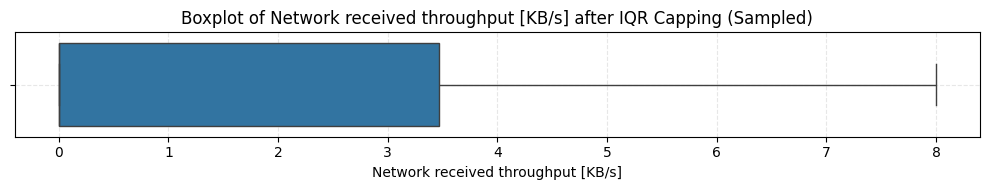

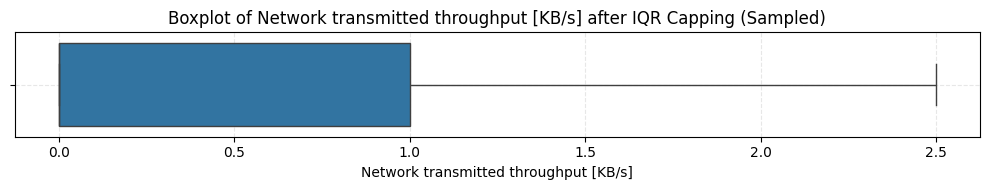

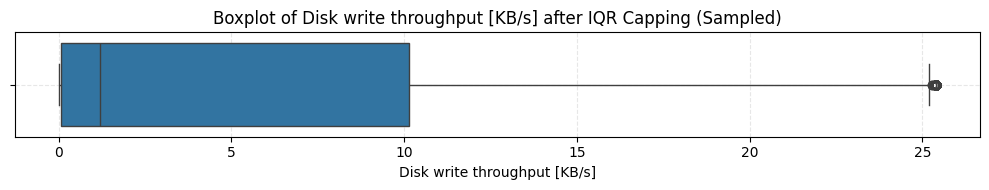

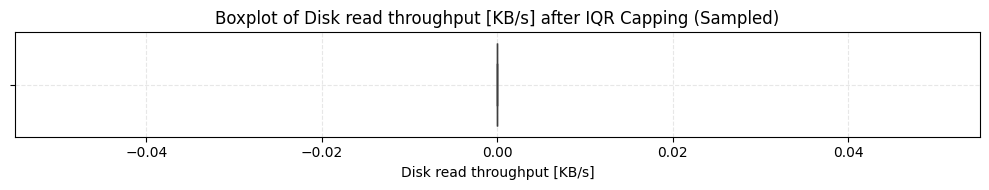

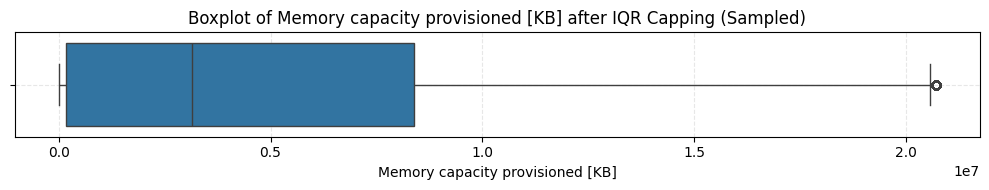

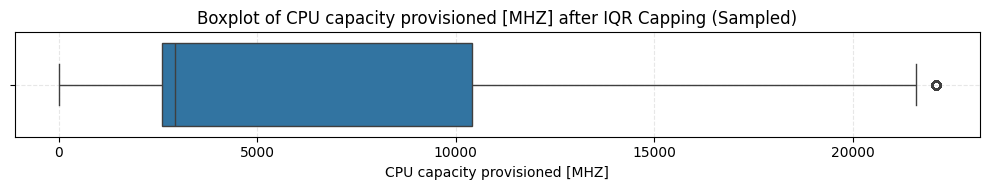

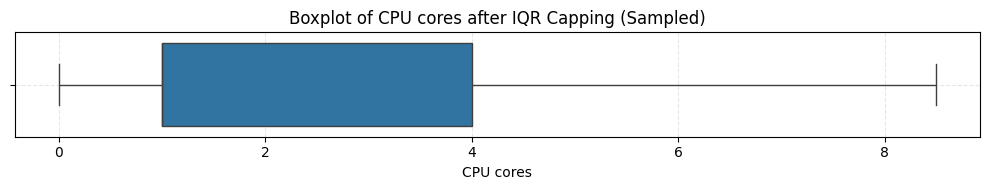

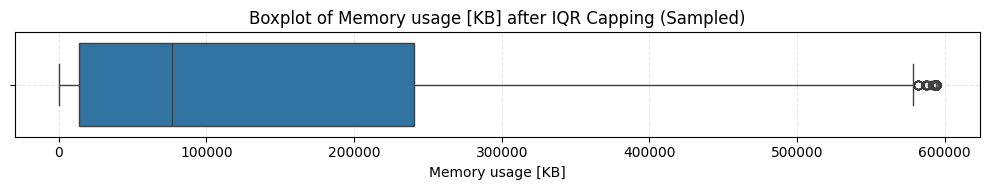

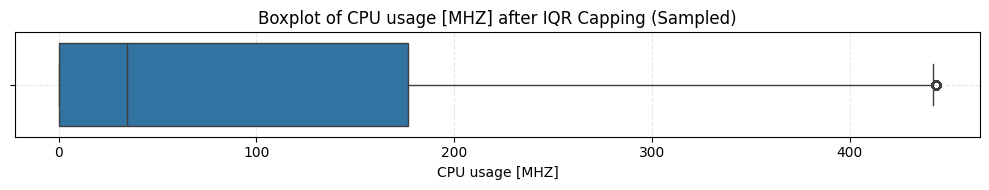

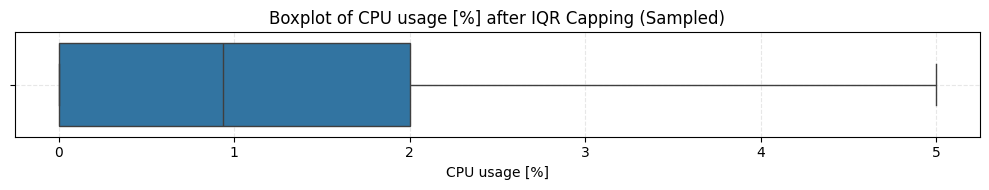

In [25]:
# ✅ Step 1: Define columns to process
cols_to_check = [
    'Network received throughput [KB/s]',
    'Network transmitted throughput [KB/s]',
    'Disk write throughput [KB/s]',
    'Disk read throughput [KB/s]',
    'Memory capacity provisioned [KB]',
    'CPU capacity provisioned [MHZ]',
    'CPU cores',
    'Memory usage [KB]',
    'CPU usage [MHZ]',
    'CPU usage [%]'
]

# ✅ Step 2: Define the capping function with outlier summary
def cap_outliers_iqr(df1, cols):
    capped_df = df1.copy()
    outlier_summary = {}

    for col in cols:
        Q1 = capped_df[col].quantile(0.25)
        Q3 = capped_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        before_outliers = ((capped_df[col] < lower) | (capped_df[col] > upper)).sum()

        # Cap values above and below the IQR range
        capped_df[col] = np.where(capped_df[col] > upper, upper,
                                  np.where(capped_df[col] < lower, lower, capped_df[col]))

        after_outliers = ((capped_df[col] < lower) | (capped_df[col] > upper)).sum()

        outlier_summary[col] = {
            "Q1": Q1,
            "Q3": Q3,
            "IQR": IQR,
            "Lower Bound": lower,
            "Upper Bound": upper,
            "Outliers Before": before_outliers,
            "Outliers After": after_outliers
        }

    return capped_df, pd.DataFrame(outlier_summary).T

# ✅ Step 3: Apply capping
df_capped, outlier_stats = cap_outliers_iqr(df, cols_to_check)

# ✅ Step 4: Display summary
print("\n📊 Outlier Summary Report (IQR Method):")
print(outlier_stats)

# ✅ Step 5: Sample for fast plotting
plot_sample = df_capped.sample(n=10000, random_state=42) if len(df_capped) > 10000 else df_capped

# ✅ Step 6: Plot boxplots after capping
for col in cols_to_check:
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=plot_sample[col])
    plt.title(f"Boxplot of {col} after IQR Capping (Sampled)")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

Numeric columns for correlation:
['Timestamp [s]', 'CPU cores', 'CPU capacity provisioned [MHZ]', 'CPU usage [MHZ]', 'CPU usage [%]', 'Memory capacity provisioned [KB]', 'Memory usage [KB]', 'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]', 'time_idx', 'time_diff']


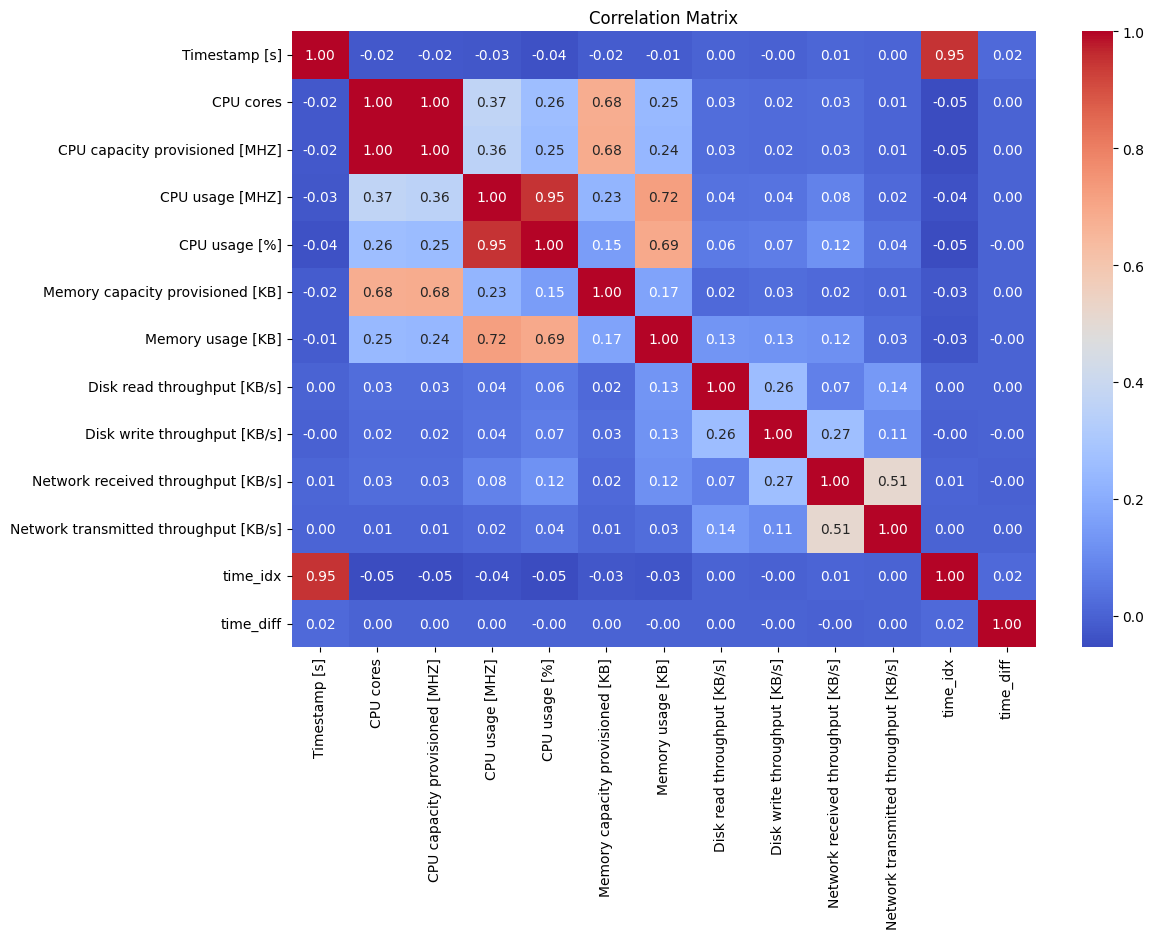

In [26]:
# Select only numeric columns (exclude object or datetime types)
numeric_cols = df1.select_dtypes(include=['number'])

# Optional: Confirm which columns are being used
print("Numeric columns for correlation:")
print(numeric_cols.columns.tolist())

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

#### Save the cleaned DataFrame to a Parquet file

In [27]:
# df1.to_parquet("/home/data/processed/PreProcessing.parquet", index=False)
df1.to_parquet("/content/drive/MyDrive/datasets/processed/PreProcessingcolab.parquet", index=False)